In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from mechir.data import CatDataCollator, DotDataCollator, MechDataset

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

In [36]:
FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'TFC1'
K = 4000
in_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

all_data_pd = pd.read_csv(in_file, sep='\t')

/scratch_local/esx208-1020836/ir_mech_interp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [37]:
def load_data(data_path):
    data = np.load(data_path)
    queries = np.load(data_path.replace("patch_head", "queries"))
    documents = np.load(data_path.replace("patch_head", "documents"))
    
    if len(queries.shape) == 3:
        queries = queries.reshape(-1, queries.shape[-1])
        documents = documents.reshape(-1, documents.shape[-1])
    
    return data, queries, documents

data_path = '/mnt/qb/work/eickhoff/esx208/MechIR/data/patching/sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco_bi_TFC1_4000_batch_size_100_patch_head.npy'
data, queries, documents = load_data(data_path)

In [38]:
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda x: x.split(' ')[-1])
all_data_pd['avg_patch_effect'] = np.mean(np.abs(data), axis=(-2,-1))
all_data_pd['avg_patch_effect_selected_heads'] = np.mean(np.abs(data)[:, [0,1,2], [9,6,3]], axis=-1)
all_data_pd['tokenized_query_length'] = all_data_pd['query'].apply(lambda x: len(tokenizer(x)['input_ids']))
all_data_pd['tokenized_doc_length'] = all_data_pd['text'].apply(lambda x: len(tokenizer(x)['input_ids']))
all_data_pd['injected_term_exists'] = all_data_pd.apply(lambda row: row['perturbed_text'].split(' ')[-1] in row['text'].lower(), axis=1)

In [39]:
all_data_pd

,qid,query,docno,text,relevance,perturbed,original_score,rank,perturbed_score,score_delta,perturbed_text,injected_term,avg_patch_effect,avg_patch_effect_selected_heads,tokenized_query_length,tokenized_doc_length,injected_term_exists
0,768208,what is mamey,3186011,This species has an elongated oblong narrow sh...,0,False,82.417656,254,100.175970,17.758316,This species has an elongated oblong narrow sh...,mamey,0.018329,0.000140,7,49,False
1,768208,what is mamey,6835292,Their size and excellent color retention prope...,0,False,79.320150,284,96.847050,17.526901,Their size and excellent color retention prope...,mamey,0.016577,0.002437,7,66,False
2,768208,what is mamey,8041502,‘I have a friend who is selling a product that...,0,False,78.457380,301,95.648750,17.191368,‘I have a friend who is selling a product that...,mamey,0.017408,0.006367,7,57,False
3,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,False,82.975464,257,99.954680,16.979218,": to add moisture to (something, such as a per...",theraderm,0.022695,0.004866,9,18,False
4,121171,define etruscans,7409541,"Fully accessible PDF installation guide, and a...",0,False,76.296555,681,92.534630,16.238075,"Fully accessible PDF installation guide, and a...",etruscans,0.015925,0.004330,6,63,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,451602,medicare's definition of mechanical ventilation,6286982,Mechanical ventilation is indicated when the p...,3,False,100.808105,45,100.882320,0.074211,Mechanical ventilation is indicated when the p...,ventilation,0.144056,0.404731,9,95,True
3996,1136962,why did the ancient egyptians call their land ...,596001,The ancient Egyptian name as transliterated fr...,3,False,105.836235,11,105.909780,0.073547,The ancient Egyptian name as transliterated fr...,call,0.047811,0.057352,17,101,True
3997,258062,how long does it take to remove wisdom tooth,4174313,The time it takes to remove the tooth will var...,3,False,109.843490,40,109.916565,0.073074,The time it takes to remove the tooth will var...,wisdom,0.066708,0.294887,11,144,True
3998,583468,what carvedilol used for,7491704,what carvedilol is and what it is used for car...,3,False,106.174270,48,106.245346,0.071075,what carvedilol is and what it is used for car...,carvedilol,0.161247,0.526062,8,112,True


In [40]:
X = all_data_pd[['tokenized_query_length', 'tokenized_doc_length', 'injected_term_exists', 'original_score', 'perturbed_score', 'score_delta', 'relevance']]
y = all_data_pd['avg_patch_effect']

X = X.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = 0.8

X_train, X_val = X.iloc[:int(train_size*len(X))], X.iloc[int(train_size*len(X)):]
y_train, y_val = y.iloc[:int(train_size*len(y))], y.iloc[int(train_size*len(y)):]

In [64]:
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, task_type='GPU')
model.fit(X_train, y_train, eval_set = (X_val, y_val), cat_features=[2], verbose=100)

0:	learn: 0.0137915	test: 0.1705276	best: 0.1705276 (0)	total: 10.7ms	remaining: 10.7s
100:	learn: 0.0131089	test: 0.1705214	best: 0.1705035 (12)	total: 672ms	remaining: 5.99s
200:	learn: 0.0126950	test: 0.1705158	best: 0.1705035 (12)	total: 1.25s	remaining: 4.97s
300:	learn: 0.0124194	test: 0.1705485	best: 0.1705035 (12)	total: 1.81s	remaining: 4.21s
400:	learn: 0.0122480	test: 0.1705462	best: 0.1705035 (12)	total: 2.34s	remaining: 3.49s
500:	learn: 0.0121663	test: 0.1705478	best: 0.1705035 (12)	total: 2.85s	remaining: 2.84s
600:	learn: 0.0120593	test: 0.1705683	best: 0.1705035 (12)	total: 3.42s	remaining: 2.27s
700:	learn: 0.0119895	test: 0.1705696	best: 0.1705035 (12)	total: 3.97s	remaining: 1.69s
800:	learn: 0.0119271	test: 0.1705736	best: 0.1705035 (12)	total: 4.51s	remaining: 1.12s
900:	learn: 0.0118457	test: 0.1705750	best: 0.1705035 (12)	total: 5.08s	remaining: 558ms
999:	learn: 0.0118028	test: 0.1705779	best: 0.1705035 (12)	total: 5.63s	remaining: 0us
bestTest = 0.1705035267
b

In [46]:
feature_importance = model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                  Feature  Importance
0  tokenized_query_length   25.155942
1    tokenized_doc_length   21.991873
4         perturbed_score   20.450885
5             score_delta   15.839131
3          original_score    7.988732
6               relevance    7.720277
2    injected_term_exists    0.853160


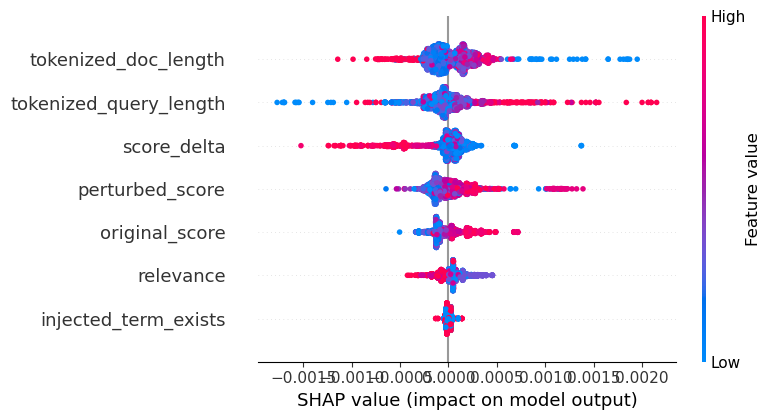

In [61]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Generate SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Visualize summary plot
shap.summary_plot(shap_values, X_train)

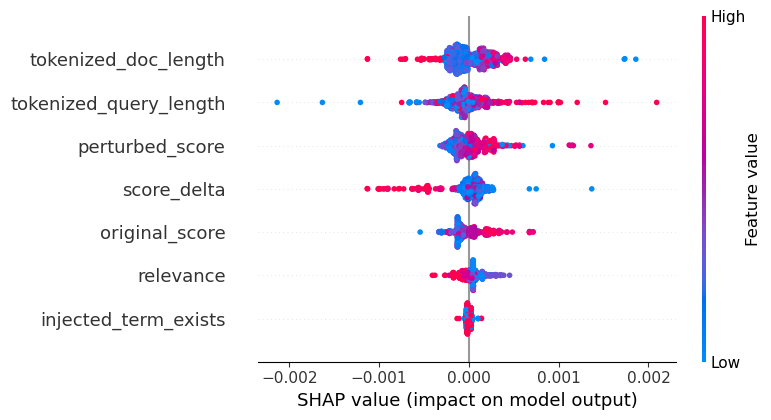

In [63]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(model)

# Generate SHAP values for the training set
shap_values = explainer.shap_values(X_val)

# Visualize summary plot
shap.summary_plot(shap_values, X_val)